In [1]:
from concurrent.futures import ALL_COMPLETED, ProcessPoolExecutor, wait
from main import MessageGenerator, OnOffServer, Sink, MessageState, Simulation, Message, run_simulation
from simulation import  SimulationParameters, SimulationResults
from typing import Dict, List

if __name__ != '__main__':
    print("Must run as __main__")
    raise RuntimeError()

n_replications = 100

varried_arrival_rates_key = "varried_arrival_rates"
varried_arrival_medium_capacity_rates_key = "varried_arrival_medium_capacity"
varried_arrival_more_capacity_rates_key = "varried_arrival_rates_more_capacity"

varried_arrival_capacity = 1
varried_arrival_medium_capacity = 10
varried_arrival_increased_capacity = 100

simulation_parameter_lists: Dict[str, List[SimulationParameters]] = dict()

# 90 minutes in ms
simulation_length = 60 * 1000

simulation_parameter_lists[varried_arrival_rates_key] = []
simulation_parameter_lists[varried_arrival_medium_capacity_rates_key] = []
simulation_parameter_lists[varried_arrival_more_capacity_rates_key] = []

for message_lambda in range(1, 10):
    simulation_parameter_lists[varried_arrival_rates_key].append(
        SimulationParameters(service_lambda=1, on_off_lambda=0.5, capacity=varried_arrival_capacity, loss_probability=1, message_lambda=message_lambda, message_lifetime=20000, simulation_length=simulation_length)
    )
    
for message_lambda in range(1, 10):
    simulation_parameter_lists[varried_arrival_more_capacity_rates_key].append(
        SimulationParameters(service_lambda=1, on_off_lambda=0.5, capacity=varried_arrival_increased_capacity, loss_probability=1, message_lambda=message_lambda, message_lifetime=20000, simulation_length=simulation_length)
    )
    
for message_lambda in range(1, 10):
    simulation_parameter_lists[varried_arrival_medium_capacity_rates_key].append(
        SimulationParameters(service_lambda=1, on_off_lambda=0.5, capacity=varried_arrival_medium_capacity, loss_probability=1, message_lambda=message_lambda, message_lifetime=20000, simulation_length=simulation_length)
    )
    
simulation_result_lists: Dict[str, List[SimulationResults]] = dict()

for key, parameters in simulation_parameter_lists.items():
    simulation_result_lists[key] = []

    for simulation_parameters in parameters:
        
        replication_results: List[SimulationResults] = []
        
        with ProcessPoolExecutor(max_workers=8) as executor:
            
            futures = []
            for i in range(n_replications):            
                result_future = executor.submit(run_simulation, simulation_parameters)
                futures.append(result_future)

            wait(futures, return_when=ALL_COMPLETED)
            
            for future in futures:
                replication_results.append(future.result())


            simulation_result_lists[key].append(
                SimulationResults(
                    n_messages_generated=(sum([result.n_messages_generated for result in replication_results]) / n_replications),
                    n_messages_lost=(sum([result.n_messages_lost for result in replication_results]) / n_replications),
                    n_messages_expired=(sum([result.n_messages_expired for result in replication_results]) / n_replications),
                    n_messages_completed=(sum([result.n_messages_completed for result in replication_results]) / n_replications),
                    averate_response_time=(sum([result.averate_response_time for result in replication_results]) / n_replications)
                )
            )

Arrival Rate Vs Response Time Graph:


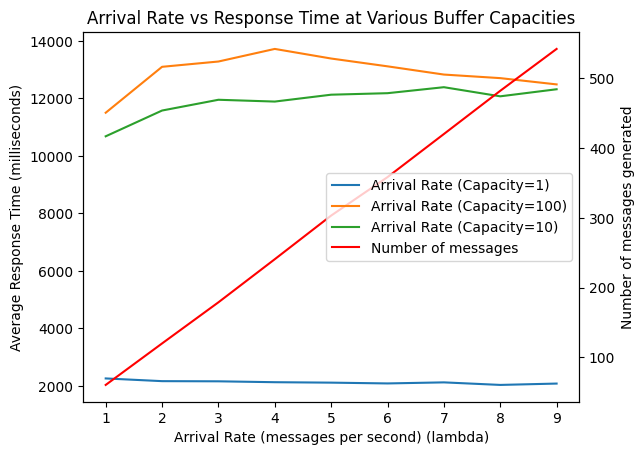

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

arrival_rate_message_lambdas: List[float] = [parameters.message_lambda for parameters in simulation_parameter_lists[varried_arrival_rates_key]]
arrival_rate_response_times: List[float] = [result.averate_response_time for result in simulation_result_lists[varried_arrival_rates_key]]
arrival_rate_n_messages_generated: List[int] = [result.n_messages_generated for result in simulation_result_lists[varried_arrival_rates_key]]

ax.plot(arrival_rate_message_lambdas, arrival_rate_response_times, label=f"Arrival Rate (Capacity={varried_arrival_capacity})")

arrival_rate_medium_capacity_message_lambdas: List[float] = [parameters.message_lambda for parameters in simulation_parameter_lists[varried_arrival_medium_capacity_rates_key]]
arrival_rate_medium_capacity_response_times: List[float] = [result.averate_response_time for result in simulation_result_lists[varried_arrival_medium_capacity_rates_key]]
arrival_rate_medium_capacity_n_messages_generated: List[int] = [result.n_messages_generated for result in simulation_result_lists[varried_arrival_medium_capacity_rates_key]]

ax.plot(arrival_rate_medium_capacity_message_lambdas, arrival_rate_medium_capacity_response_times, label=f"Arrival Rate (Capacity={varried_arrival_medium_capacity})")


arrival_rate_more_capacity_message_lambdas: List[float] = [parameters.message_lambda for parameters in simulation_parameter_lists[varried_arrival_more_capacity_rates_key]]
arrival_rate_more_capacity_response_times: List[float] = [result.averate_response_time for result in simulation_result_lists[varried_arrival_more_capacity_rates_key]]
arrival_rate_more_capacity_n_messages_generated: List[int] = [result.n_messages_generated for result in simulation_result_lists[varried_arrival_more_capacity_rates_key]]

ax.plot(arrival_rate_more_capacity_message_lambdas, arrival_rate_more_capacity_response_times, label=f"Arrival Rate (Capacity={varried_arrival_increased_capacity})")


ax1 = ax.twinx()
ax1.plot(arrival_rate_message_lambdas, arrival_rate_n_messages_generated, color="red", label="Number of messages")

ax.set_xlabel(xlabel="Arrival Rate (messages per second) (lambda)")
ax.set_ylabel(ylabel="Average Response Time (milliseconds)")

ax1.set_ylabel(ylabel="Number of messages generated")


# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="center right")

ax.set_title("Arrival Rate vs Response Time at Various Buffer Capacities")


print("Arrival Rate Vs Response Time Graph:")
